# Optimization Sandbox

Goal is to find the global "most optimal" points for water sources (destinations of supply) among a large set of homes and corrals (origins of demand). For now, we're minimizing the average traveling time from a cluster of origins to a destiantion.

In [73]:
import numpy as np
from numpy import random as rand
from scipy.interpolate import make_interp_spline
import scipy.optimize._dual_annealing
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)  # Removes scientific notation, etc.

## Abstract Examples
Experimenting with different optimization methods with arbitrary examples.

Here, we globally optimize a continuous function with local extrema with a continuous bounding function (to determine the minimum a minima can be, etc.).

In [141]:
def gen_ex_func(num_pts = 64) -> tuple[np.ndarray, np.ndarray]:
  """
  Generates a random example function to optimize with exaggerated local extrema, given the number of points to interpolate from
  """
  x_vals = np.arange(num_pts)
  y_vals = rand.gumbel(size=num_pts)  # Skewed distribution to occasionally generate much larger values for extrema

  spline = make_interp_spline(x_vals, y=y_vals)
  x_vals = np.linspace(0, x_vals.max(), 512)
  return x_vals, spline(x_vals)

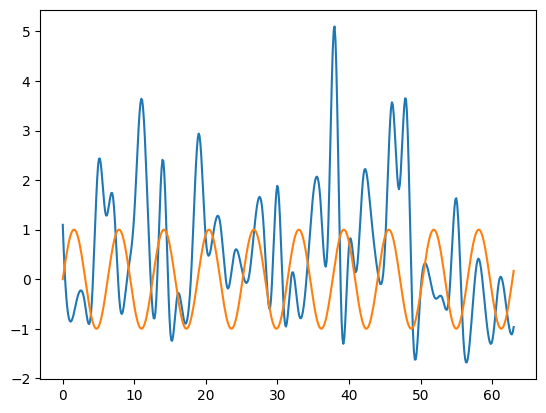

In [158]:
x_vals, y_vals = gen_ex_func()

fig, ax = plt.subplots()
ax.plot(x_vals, y_vals)
ax.plot(x_vals, np.sin(x_vals))

## Simulated Annealing
**Note:** `scipy.optimize.anneal` deprecated in favor of `scipy.optimize.basinhopping`.
We're testing this on a randomly generated $32 \times 2$ array that represents 32 random coordinates (each coordinate in $[0, 100)$).

In [25]:
def gen_rand_coords(num_coords = 1, lo = 0, up = 100) -> tuple[np.ndarray, np.ndarray]:
  """
  Generates random coordinates given number of coordinates within [lower bound, upper bound)
  """
  return rand.rand(num_coords, 2) * up + lo

In [26]:
origins = gen_rand_coords(100) # Homes/corrals
dests = gen_rand_coords(16) # Water sources

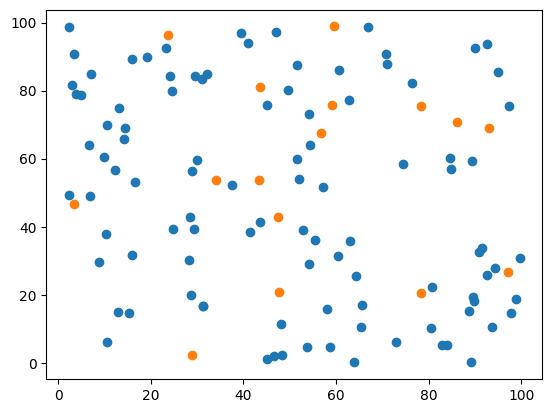

In [27]:
fig, ax = plt.subplots()

ax.scatter(origins[:,0], origins[:,1]) # Blue
ax.scatter(dests[:, 0], dests[:, 1]) # Orange

In [11]:
def avg_dist_from_pt(pt: np.ndarray, arr: np.ndarray) -> float:
  """
  Calculates average distance that an array of points are from a point
  """
  sum = 0
  for arr_pt in arr:
    sum += np.linalg.norm(pt - arr_pt)
  return sum / arr.size

Absolute optimization example (control result to compare against)

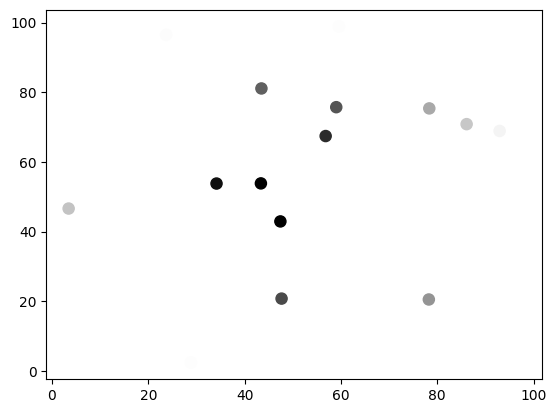

In [28]:
avgs = np.array([avg_dist_from_pt(dest, origins) for dest in dests])

fig, ax = plt.subplots()
ax.scatter(dests[:, 0], dests[:, 1], c=avgs, s=64) # s is a size of marker 
plt.gray()